In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
import random
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "without batch normalization_FedAvg_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 100, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

transfer_i = random.randint(0, 3)
configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.5):
    trainloader = []
    valloader = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        print(data.size())
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        print(data_resampled.shape)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        train_size = int(train_ratio * len(dataset))
        test_size = len(dataset) - train_size
        val_size = int(val_ratio * test_size)
        test_size = test_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        if i == transfer_i:
            trainloader_transfer = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valloader_transfer = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        else:
            trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
            valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))
            
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 52.554744720458984 Testing accuracy: 47.445255279541016.

Epoch 2/100
Epoch 2: Training accuracy: 55.83941650390625 Testing accuracy: 62.04379653930664.

Epoch 3/100
Epoch 3: Training accuracy: 57.937957763671875 Testing accuracy: 59.124088287353516.

Epoch 4/100
Epoch 4: Training accuracy: 58.029197692871094 Testing accuracy: 60.58394241333008.

Epoch 5/100
Epoch 5: Training accuracy: 58.94160461425781 Testing accuracy: 59.124088287353516.

Epoch 6/100
Epoch 6: Training accuracy: 61.22262954711914 Testing accuracy: 64.9635009765625.

Epoch 7/100
Epoch 7: Training accuracy: 62.22627639770508 Testing accuracy: 63.5036506652832.

Epoch 8/100
Epoch 8: Training accuracy: 62.04379653930664 Testing accuracy: 61.31386947631836.

Epoch 9/100
Epoch 9: Training accuracy: 67.42700958251953 Testing accuracy: 67.15328216552734.

Epoch 10/100
Epoch 10: Training accuracy: 66.60584259033203 Testing accuracy: 66.42335510253906.

Epoch 11/100
Epoch 11: Training a

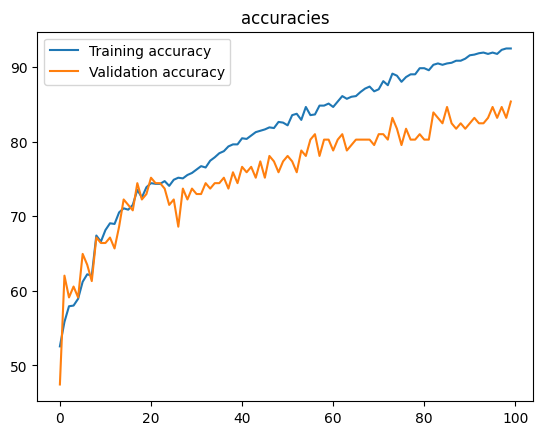

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## transfer learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

torch.Size([1002, 4, 50])
(1670, 4, 50)
torch.Size([936, 4, 50])
(1560, 4, 50)
torch.Size([1242, 4, 50])
(2070, 4, 50)
torch.Size([1014, 4, 50])
(1690, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 50.08012771606445 Testing accuracy: 51.28205108642578.

Epoch 2/100
Epoch 2: Training accuracy: 59.61538314819336 Testing accuracy: 57.69230651855469.

Epoch 3/100
Epoch 3: Training accuracy: 64.66345977783203 Testing accuracy: 61.53845977783203.

Epoch 4/100
Epoch 4: Training accuracy: 67.78845977783203 Testing accuracy: 67.30769348144531.

Epoch 5/100
Epoch 5: Training accuracy: 70.1121826171875 Testing accuracy: 69.23076629638672.

Epoch 6/100
Epoch 6: Training accuracy: 70.59294891357422 Testing accuracy: 69.23076629638672.

Epoch 7/100
Epoch 7: Training accuracy: 72.91666412353516 Testing accuracy: 69.87179565429688.

Epoch 8/100
Epoch 8: Training accuracy: 73.07691955566406 Testing accuracy: 71.15384674072266.

Epoch 9/100
Epoch 9: Training accuracy: 75.08013153076172 Testing accuracy: 73.07691955566406.

Epoch 10/100
Epoch 10: Training accuracy: 75.72115325927734 Testing accuracy: 71.79486846923828.

Epoch 11/100
Epoch 11: Training accura

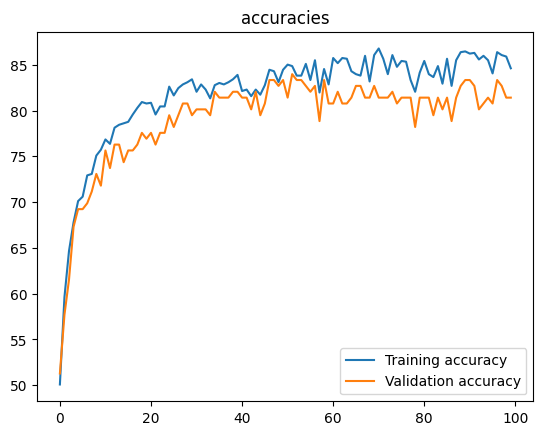

In [8]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'])
    loss, accuracy = test(net, azure_val_loaders_transfer, configuration)
    losses_transfer.append(loss)
    accuracies_transfer.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Learning

In [9]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [10]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [12]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=100, no round_timeout
2024-08-12 12:20:01,379	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'object_store_memory': 56810865868.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'node:__internal_head__': 1.0, 'memory': 122558687028.0, 'node:192.168.1.146': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO 

Server-side evaluation loss 0.06810850446874445 / accuracy 51.50214767456055
(ClientAppActor pid=2247181) 
(ClientAppActor pid=2247181) Epoch 1/100
(ClientAppActor pid=2247181) Epoch 1: Training accuracy: 48.96449661254883 Testing accuracy: 55.02958679199219.
(ClientAppActor pid=2247181) Epoch 2: Training accuracy: 48.96449661254883 Testing accuracy: 55.02958679199219.


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.06300483508543535, {'accuracy': tensor(48.4979, device='cuda:0')}, 6.335179380024783)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247181)  [repeated 299x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2247181) Epoch 100/100 [repeated 299x across cluster]
Server-side evaluation loss 0.06300483508543535 / accuracy 48.49785232543945
(ClientAppActor pid=2247181) Epoch 6: Training accuracy: 62.87425231933594 Testing accuracy: 59.88024139404297. [repeated 305x across cluster]
(ClientAppActor pid=2247181)  [repeated 287x across cluster]
(ClientAppActor pid=2247181) Epoch 87/100 [repeated 287x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=2247181) Epoch 93: Training accuracy: 62.077293395996094 Testing accuracy: 61.352657318115234. [repeated 286x across cluster]


INFO :      fit progress: (2, 0.06273838064887306, {'accuracy': tensor(64.3777, device='cuda:0')}, 11.806584189995192)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.06273838064887306 / accuracy 64.377685546875
(ClientAppActor pid=2247181)  [repeated 298x across cluster]
(ClientAppActor pid=2247181) Epoch 85/100 [repeated 298x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.06055519797585227, {'accuracy': tensor(76.2518, device='cuda:0')}, 16.86658571206499)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=2247181) Epoch 93: Training accuracy: 64.89521026611328 Testing accuracy: 68.86227416992188. [repeated 300x across cluster]
Server-side evaluation loss 0.06055519797585227 / accuracy 76.25178527832031


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247182)  [repeated 286x across cluster]
(ClientAppActor pid=2247182) Epoch 71/100 [repeated 286x across cluster]
(ClientAppActor pid=2247182) Epoch 77: Training accuracy: 70.53140258789062 Testing accuracy: 71.01449584960938. [repeated 284x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.05668346990238537, {'accuracy': tensor(75.9657, device='cuda:0')}, 22.442900302005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05668346990238537 / accuracy 75.96566772460938
(ClientAppActor pid=2247181)  [repeated 296x across cluster]
(ClientAppActor pid=2247181) Epoch 67/100 [repeated 296x across cluster]
(ClientAppActor pid=2247181) Epoch 74: Training accuracy: 73.72754669189453 Testing accuracy: 71.85628509521484. [repeated 297x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.05542629957199097, {'accuracy': tensor(74.9642, device='cuda:0')}, 27.45798112801276)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05542629957199097 / accuracy 74.9642333984375
(ClientAppActor pid=2247182)  [repeated 300x across cluster]
(ClientAppActor pid=2247182) Epoch 67/100 [repeated 300x across cluster]
(ClientAppActor pid=2247182) Epoch 74: Training accuracy: 71.4820327758789 Testing accuracy: 67.06586456298828. [repeated 300x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.05449001897465099, {'accuracy': tensor(76.1087, device='cuda:0')}, 32.55147388810292)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05449001897465099 / accuracy 76.10872650146484
(ClientAppActor pid=2247181)  [repeated 301x across cluster]
(ClientAppActor pid=2247181) Epoch 68/100 [repeated 301x across cluster]
(ClientAppActor pid=2247181) Epoch 75: Training accuracy: 72.04141998291016 Testing accuracy: 69.8224868774414. [repeated 301x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.053756773471832275, {'accuracy': tensor(75.5365, device='cuda:0')}, 37.62174940307159)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053756773471832275 / accuracy 75.53648376464844
(ClientAppActor pid=2247181)  [repeated 302x across cluster]
(ClientAppActor pid=2247181) Epoch 70/100 [repeated 302x across cluster]
(ClientAppActor pid=2247181) Epoch 77: Training accuracy: 73.00296020507812 Testing accuracy: 69.8224868774414. [repeated 302x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.05335597558455034, {'accuracy': tensor(77.5393, device='cuda:0')}, 42.64560063101817)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05335597558455034 / accuracy 77.53934478759766
(ClientAppActor pid=2247182)  [repeated 298x across cluster]
(ClientAppActor pid=2247182) Epoch 68/100 [repeated 298x across cluster]
(ClientAppActor pid=2247182) Epoch 76: Training accuracy: 73.50299072265625 Testing accuracy: 76.6467056274414. [repeated 299x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (9, 0.053221957250074906, {'accuracy': tensor(78.3977, device='cuda:0')}, 47.736505947075784)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053221957250074906 / accuracy 78.39771270751953
(ClientAppActor pid=2247182)  [repeated 290x across cluster]
(ClientAppActor pid=2247182) Epoch 58/100 [repeated 290x across cluster]
(ClientAppActor pid=2247182) Epoch 64: Training accuracy: 75.5434799194336 Testing accuracy: 76.32849884033203. [repeated 288x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.05321722680872137, {'accuracy': tensor(77.9685, device='cuda:0')}, 53.34056852210779)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05321722680872137 / accuracy 77.9685287475586
(ClientAppActor pid=2247182)  [repeated 287x across cluster]
(ClientAppActor pid=2247182) Epoch 45/100 [repeated 287x across cluster]
(ClientAppActor pid=2247182) Epoch 53: Training accuracy: 73.95209503173828 Testing accuracy: 78.443115234375. [repeated 289x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.05435281991958618, {'accuracy': tensor(75.9657, device='cuda:0')}, 58.48653989308514)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05435281991958618 / accuracy 75.96566772460938
(ClientAppActor pid=2247181)  [repeated 295x across cluster]
(ClientAppActor pid=2247181) Epoch 40/100 [repeated 295x across cluster]
(ClientAppActor pid=2247181) Epoch 46: Training accuracy: 74.69806671142578 Testing accuracy: 72.94686126708984. [repeated 293x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.05357713049108332, {'accuracy': tensor(76.9671, device='cuda:0')}, 64.09056662407238)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05357713049108332 / accuracy 76.96709442138672
(ClientAppActor pid=2247182)  [repeated 286x across cluster]
(ClientAppActor pid=2247182) Epoch 26/100 [repeated 286x across cluster]
(ClientAppActor pid=2247182) Epoch 33: Training accuracy: 74.63018035888672 Testing accuracy: 72.78106689453125. [repeated 287x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (13, 0.05446691404689442, {'accuracy': tensor(75.8226, device='cuda:0')}, 69.2126453591045)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05446691404689442 / accuracy 75.82260131835938
(ClientAppActor pid=2247181)  [repeated 297x across cluster]
(ClientAppActor pid=2247181) Epoch 23/100 [repeated 297x across cluster]
(ClientAppActor pid=2247181) Epoch 28: Training accuracy: 73.91304016113281 Testing accuracy: 74.39613342285156. [repeated 295x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.0532611066644842, {'accuracy': tensor(77.5393, device='cuda:0')}, 74.7300120650325)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0532611066644842 / accuracy 77.53934478759766
(ClientAppActor pid=2247181)  [repeated 283x across cluster]
(ClientAppActor pid=2247181) Epoch 6/100 [repeated 283x across cluster]
(ClientAppActor pid=2247181) Epoch 12: Training accuracy: 75.4227066040039 Testing accuracy: 76.81159210205078. [repeated 284x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.05310886014591564, {'accuracy': tensor(78.2546, device='cuda:0')}, 80.27893408306409)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05310886014591564 / accuracy 78.25464630126953
(ClientAppActor pid=2247181)  [repeated 253x across cluster]
(ClientAppActor pid=2247181) Epoch 90/100 [repeated 253x across cluster]
(ClientAppActor pid=2247181) Epoch 98: Training accuracy: 75.37425231933594 Testing accuracy: 78.443115234375. [repeated 261x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 0.05291092937642878, {'accuracy': tensor(78.2546, device='cuda:0')}, 85.3070523540955)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05291092937642878 / accuracy 78.25464630126953
(ClientAppActor pid=2247181)  [repeated 317x across cluster]
(ClientAppActor pid=2247181) Epoch 90/100 [repeated 317x across cluster]
(ClientAppActor pid=2247181) Epoch 97: Training accuracy: 74.77810668945312 Testing accuracy: 76.92308044433594. [repeated 317x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.0529062802141363, {'accuracy': tensor(78.2546, device='cuda:0')}, 90.91129679803271)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0529062802141363 / accuracy 78.25464630126953
(ClientAppActor pid=2247181)  [repeated 259x across cluster]
(ClientAppActor pid=2247181) Epoch 71/100 [repeated 259x across cluster]
(ClientAppActor pid=2247181) Epoch 78: Training accuracy: 76.42215728759766 Testing accuracy: 79.04191589355469. [repeated 259x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.05287776751951738, {'accuracy': tensor(78.3977, device='cuda:0')}, 96.43821271904744)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05287776751951738 / accuracy 78.39771270751953
(ClientAppActor pid=2247181)  [repeated 258x across cluster]
(ClientAppActor pid=2247181) Epoch 54/100 [repeated 258x across cluster]
(ClientAppActor pid=2247181) Epoch 61: Training accuracy: 77.17066192626953 Testing accuracy: 78.443115234375. [repeated 257x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.053005673668601296, {'accuracy': tensor(77.9685, device='cuda:0')}, 101.46103416208643)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053005673668601296 / accuracy 77.9685287475586
(ClientAppActor pid=2247181)  [repeated 298x across cluster]
(ClientAppActor pid=2247181) Epoch 44/100 [repeated 298x across cluster]
(ClientAppActor pid=2247181) Epoch 49: Training accuracy: 76.08695983886719 Testing accuracy: 77.29468536376953. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.052542556415904655, {'accuracy': tensor(79.1130, device='cuda:0')}, 106.64470582210924)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.052542556415904655 / accuracy 79.11302185058594
(ClientAppActor pid=2247181)  [repeated 291x across cluster]
(ClientAppActor pid=2247181) Epoch 47/100 [repeated 291x across cluster]
(ClientAppActor pid=2247181) Epoch 54: Training accuracy: 75.07396697998047 Testing accuracy: 76.92308044433594. [repeated 293x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.05295896530151367, {'accuracy': tensor(78.2546, device='cuda:0')}, 111.79242293501738)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05295896530151367 / accuracy 78.25464630126953
(ClientAppActor pid=2247181)  [repeated 310x across cluster]
(ClientAppActor pid=2247181) Epoch 48/100 [repeated 310x across cluster]
(ClientAppActor pid=2247181) Epoch 55: Training accuracy: 75.22189331054688 Testing accuracy: 76.92308044433594. [repeated 311x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 0.05328269438310103, {'accuracy': tensor(77.8255, device='cuda:0')}, 117.39316707407124)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05328269438310103 / accuracy 77.8254623413086
(ClientAppActor pid=2247181)  [repeated 254x across cluster]
(ClientAppActor pid=2247181) Epoch 23/100 [repeated 254x across cluster]
(ClientAppActor pid=2247181) Epoch 28: Training accuracy: 73.97342681884766 Testing accuracy: 74.39613342285156. [repeated 252x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.05244049700823697, {'accuracy': tensor(78.9700, device='cuda:0')}, 122.62578496907372)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05244049700823697 / accuracy 78.96995544433594
(ClientAppActor pid=2247181)  [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 21/100 [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 28: Training accuracy: 75.51775360107422 Testing accuracy: 76.92308044433594. [repeated 290x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.05232774669473821, {'accuracy': tensor(78.9700, device='cuda:0')}, 127.69527103903238)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05232774669473821 / accuracy 78.96995544433594
(ClientAppActor pid=2247181)  [repeated 301x across cluster]
(ClientAppActor pid=2247181) Epoch 18/100 [repeated 300x across cluster]
(ClientAppActor pid=2247181) Epoch 24: Training accuracy: 76.63043212890625 Testing accuracy: 77.77777862548828. [repeated 301x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.05348713831468062, {'accuracy': tensor(77.3963, device='cuda:0')}, 132.94902455201373)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05348713831468062 / accuracy 77.39627838134766
(ClientAppActor pid=2247181)  [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 13/100 [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 18: Training accuracy: 76.32849884033203 Testing accuracy: 75.84541320800781. [repeated 287x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (26, 0.053021284666928375, {'accuracy': tensor(78.2546, device='cuda:0')}, 138.08902977209073)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053021284666928375 / accuracy 78.25464630126953
(ClientAppActor pid=2247181)  [repeated 296x across cluster]
(ClientAppActor pid=2247181) Epoch 13/100 [repeated 296x across cluster]
(ClientAppActor pid=2247181) Epoch 20: Training accuracy: 77.76946258544922 Testing accuracy: 79.64071655273438. [repeated 297x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 0.05257036469199441, {'accuracy': tensor(78.5408, device='cuda:0')}, 143.1080326680094)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05257036469199441 / accuracy 78.540771484375
(ClientAppActor pid=2247181)  [repeated 304x across cluster]
(ClientAppActor pid=2247181) Epoch 16/100 [repeated 304x across cluster]
(ClientAppActor pid=2247181) Epoch 23: Training accuracy: 77.76946258544922 Testing accuracy: 79.64071655273438. [repeated 304x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (28, 0.051714187318628486, {'accuracy': tensor(78.6838, device='cuda:0')}, 148.25629862910137)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051714187318628486 / accuracy 78.68383026123047
(ClientAppActor pid=2247181)  [repeated 293x across cluster]
(ClientAppActor pid=2247181) Epoch 10/100 [repeated 293x across cluster]
(ClientAppActor pid=2247181) Epoch 16: Training accuracy: 77.113525390625 Testing accuracy: 79.22705078125. [repeated 293x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (29, 0.053270697593688965, {'accuracy': tensor(77.3963, device='cuda:0')}, 153.58051441400312)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053270697593688965 / accuracy 77.39627838134766
(ClientAppActor pid=2247181)  [repeated 285x across cluster]
(ClientAppActor pid=2247181) Epoch 2/100 [repeated 285x across cluster]
(ClientAppActor pid=2247181) Epoch 10: Training accuracy: 78.21855926513672 Testing accuracy: 80.23951721191406. [repeated 285x across cluster]
(ClientAppActor pid=2247181)  [repeated 286x across cluster]
(ClientAppActor pid=2247181) Epoch 88/100 [repeated 286x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=2247181) Epoch 93: Training accuracy: 76.87197875976562 Testing accuracy: 77.29468536376953. [repeated 278x across cluster]


INFO :      fit progress: (30, 0.051842250607230446, {'accuracy': tensor(77.2532, device='cuda:0')}, 159.16230051103048)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051842250607230446 / accuracy 77.25321960449219
(ClientAppActor pid=2247182)  [repeated 293x across cluster]
(ClientAppActor pid=2247182) Epoch 81/100 [repeated 293x across cluster]
(ClientAppActor pid=2247182) Epoch 88: Training accuracy: 75.07396697998047 Testing accuracy: 81.65680694580078. [repeated 295x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (31, 0.05207496339624578, {'accuracy': tensor(78.8269, device='cuda:0')}, 164.27689825603738)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05207496339624578 / accuracy 78.82689666748047
(ClientAppActor pid=2247182)  [repeated 295x across cluster]
(ClientAppActor pid=2247182) Epoch 76/100 [repeated 295x across cluster]
(ClientAppActor pid=2247182) Epoch 84: Training accuracy: 75.67365264892578 Testing accuracy: 76.6467056274414. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (32, 0.051354792985049164, {'accuracy': tensor(78.9700, device='cuda:0')}, 169.4505530130118)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051354792985049164 / accuracy 78.96995544433594
(ClientAppActor pid=2247182)  [repeated 285x across cluster]
(ClientAppActor pid=2247182) Epoch 61/100 [repeated 285x across cluster]
(ClientAppActor pid=2247182) Epoch 67: Training accuracy: 76.32849884033203 Testing accuracy: 76.81159210205078. [repeated 283x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (33, 0.05268219384280118, {'accuracy': tensor(77.6824, device='cuda:0')}, 175.15408669004682)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05268219384280118 / accuracy 77.68240356445312
(ClientAppActor pid=2247181)  [repeated 279x across cluster]
(ClientAppActor pid=2247181) Epoch 40/100 [repeated 279x across cluster]
(ClientAppActor pid=2247181) Epoch 46: Training accuracy: 77.35507202148438 Testing accuracy: 76.32849884033203. [repeated 279x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (34, 0.05129907347939231, {'accuracy': tensor(79.1130, device='cuda:0')}, 180.8497047451092)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05129907347939231 / accuracy 79.11302185058594
(ClientAppActor pid=2247182)  [repeated 279x across cluster]
(ClientAppActor pid=2247182) Epoch 19/100 [repeated 279x across cluster]
(ClientAppActor pid=2247182) Epoch 25: Training accuracy: 77.29468536376953 Testing accuracy: 77.29468536376953. [repeated 279x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (35, 0.051199712536551735, {'accuracy': tensor(79.2561, device='cuda:0')}, 186.5450377369998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051199712536551735 / accuracy 79.2560806274414
(ClientAppActor pid=2247181)  [repeated 255x across cluster]
(ClientAppActor pid=2247181) Epoch 97/100 [repeated 255x across cluster]
(ClientAppActor pid=2247181) Epoch 3: Training accuracy: 75.89820098876953 Testing accuracy: 79.64071655273438. [repeated 260x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (36, 0.051011388952081856, {'accuracy': tensor(79.2561, device='cuda:0')}, 191.64806768507697)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051011388952081856 / accuracy 79.2560806274414
(ClientAppActor pid=2247181)  [repeated 301x across cluster]
(ClientAppActor pid=2247181) Epoch 98/100 [repeated 301x across cluster]
(ClientAppActor pid=2247181) Epoch 4: Training accuracy: 78.3682632446289 Testing accuracy: 80.23951721191406. [repeated 302x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (37, 0.05139121142300693, {'accuracy': tensor(78.6838, device='cuda:0')}, 196.7285245480016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05139121142300693 / accuracy 78.68383026123047
(ClientAppActor pid=2247181)  [repeated 321x across cluster]
(ClientAppActor pid=2247181) Epoch 99/100 [repeated 321x across cluster]
(ClientAppActor pid=2247182) Epoch 5: Training accuracy: 77.71739196777344 Testing accuracy: 78.74396514892578. [repeated 318x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (38, 0.050030545754866165, {'accuracy': tensor(79.3991, device='cuda:0')}, 202.3358345410088)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050030545754866165 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 245x across cluster]
(ClientAppActor pid=2247181) Epoch 81/100 [repeated 245x across cluster]
(ClientAppActor pid=2247181) Epoch 87: Training accuracy: 79.34131622314453 Testing accuracy: 80.83832550048828. [repeated 248x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (39, 0.049562053246931595, {'accuracy': tensor(79.3991, device='cuda:0')}, 207.46250782406423)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.049562053246931595 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 295x across cluster]
(ClientAppActor pid=2247181) Epoch 78/100 [repeated 295x across cluster]
(ClientAppActor pid=2247181) Epoch 86: Training accuracy: 79.34131622314453 Testing accuracy: 80.83832550048828. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (40, 0.04939661242745139, {'accuracy': tensor(79.3991, device='cuda:0')}, 212.5807453300804)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04939661242745139 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 296x across cluster]
(ClientAppActor pid=2247181) Epoch 74/100 [repeated 296x across cluster]
(ClientAppActor pid=2247181) Epoch 81: Training accuracy: 76.775146484375 Testing accuracy: 77.5147933959961. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (41, 0.04893537543036721, {'accuracy': tensor(79.3991, device='cuda:0')}, 217.76767898409162)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04893537543036721 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 69/100 [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 75: Training accuracy: 77.36686706542969 Testing accuracy: 77.5147933959961. [repeated 288x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (42, 0.04837510802529075, {'accuracy': tensor(79.5422, device='cuda:0')}, 222.92274993599858)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04837510802529075 / accuracy 79.54220581054688
(ClientAppActor pid=2247181)  [repeated 309x across cluster]
(ClientAppActor pid=2247181) Epoch 66/100 [repeated 309x across cluster]
(ClientAppActor pid=2247181) Epoch 73: Training accuracy: 77.81065368652344 Testing accuracy: 79.2899398803711. [repeated 311x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (43, 0.04843643036755649, {'accuracy': tensor(79.1130, device='cuda:0')}, 228.59079955809284)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04843643036755649 / accuracy 79.11302185058594
(ClientAppActor pid=2247181)  [repeated 255x across cluster]
(ClientAppActor pid=2247181) Epoch 46/100 [repeated 255x across cluster]
(ClientAppActor pid=2247181) Epoch 53: Training accuracy: 78.29341125488281 Testing accuracy: 78.443115234375. [repeated 255x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (44, 0.04823777892372825, {'accuracy': tensor(79.3991, device='cuda:0')}, 234.18170664506033)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04823777892372825 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 261x across cluster]
(ClientAppActor pid=2247181) Epoch 25/100 [repeated 261x across cluster]
(ClientAppActor pid=2247181) Epoch 32: Training accuracy: 78.47633361816406 Testing accuracy: 81.65680694580078. [repeated 261x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (45, 0.04809260368347168, {'accuracy': tensor(78.9700, device='cuda:0')}, 239.94784260808956)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247182)  [repeated 254x across cluster]
(ClientAppActor pid=2247182) Epoch 100/100 [repeated 254x across cluster]
Server-side evaluation loss 0.04809260368347168 / accuracy 78.96995544433594
(ClientAppActor pid=2247181) Epoch 4: Training accuracy: 79.28743743896484 Testing accuracy: 80.67633056640625. [repeated 245x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (46, 0.047542035579681396, {'accuracy': tensor(80.5436, device='cuda:0')}, 245.14974856108893)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247182)  [repeated 296x across cluster]
(ClientAppActor pid=2247182) Epoch 96/100 [repeated 296x across cluster]
Server-side evaluation loss 0.047542035579681396 / accuracy 80.54363250732422
(ClientAppActor pid=2247182) Epoch 99: Training accuracy: 79.65975952148438 Testing accuracy: 82.24851989746094. [repeated 294x across cluster]
(ClientAppActor pid=2247182)  [repeated 296x across cluster]
(ClientAppActor pid=2247182) Epoch 92/100 [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (47, 0.04894620721990412, {'accuracy': tensor(77.9685, device='cuda:0')}, 250.40056726709008)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247182) Epoch 99: Training accuracy: 76.42215728759766 Testing accuracy: 72.45509338378906. [repeated 300x across cluster]
Server-side evaluation loss 0.04894620721990412 / accuracy 77.9685287475586
(ClientAppActor pid=2247182)  [repeated 295x across cluster]
(ClientAppActor pid=2247182) Epoch 87/100 [repeated 295x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (48, 0.04718183929269964, {'accuracy': tensor(79.6853, device='cuda:0')}, 255.56832201906946)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=2247182) Epoch 94: Training accuracy: 79.95561981201172 Testing accuracy: 82.24851989746094. [repeated 295x across cluster]
Server-side evaluation loss 0.04718183929269964 / accuracy 79.68526458740234


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247181)  [repeated 299x across cluster]
(ClientAppActor pid=2247181) Epoch 86/100 [repeated 299x across cluster]
(ClientAppActor pid=2247181) Epoch 93: Training accuracy: 79.80769348144531 Testing accuracy: 81.65680694580078. [repeated 299x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (49, 0.047321975231170654, {'accuracy': tensor(80.4006, device='cuda:0')}, 260.6693800711073)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047321975231170654 / accuracy 80.40057373046875
(ClientAppActor pid=2247182)  [repeated 295x across cluster]
(ClientAppActor pid=2247182) Epoch 81/100 [repeated 295x across cluster]
(ClientAppActor pid=2247182) Epoch 88: Training accuracy: 76.94610595703125 Testing accuracy: 77.2455062866211. [repeated 295x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (50, 0.047835252501747826, {'accuracy': tensor(78.5408, device='cuda:0')}, 265.8709687771043)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047835252501747826 / accuracy 78.540771484375
(ClientAppActor pid=2247181)  [repeated 283x across cluster]
(ClientAppActor pid=2247181) Epoch 64/100 [repeated 283x across cluster]
(ClientAppActor pid=2247181) Epoch 70: Training accuracy: 79.46859741210938 Testing accuracy: 77.77777862548828. [repeated 282x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (51, 0.04758195985447277, {'accuracy': tensor(79.2561, device='cuda:0')}, 271.5524476020364)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04758195985447277 / accuracy 79.2560806274414
(ClientAppActor pid=2247181)  [repeated 283x across cluster]
(ClientAppActor pid=2247181) Epoch 46/100 [repeated 282x across cluster]
(ClientAppActor pid=2247181) Epoch 51: Training accuracy: 79.40821075439453 Testing accuracy: 78.74396514892578. [repeated 281x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (52, 0.04725941202857278, {'accuracy': tensor(79.3991, device='cuda:0')}, 277.18238600110635)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04725941202857278 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 288x across cluster]
(ClientAppActor pid=2247181) Epoch 34/100 [repeated 288x across cluster]
(ClientAppActor pid=2247181) Epoch 41: Training accuracy: 81.88623046875 Testing accuracy: 78.443115234375. [repeated 290x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (53, 0.04704109105196866, {'accuracy': tensor(79.6853, device='cuda:0')}, 282.32668654609006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04704109105196866 / accuracy 79.68526458740234
(ClientAppActor pid=2247182)  [repeated 294x across cluster]
(ClientAppActor pid=2247182) Epoch 28/100 [repeated 294x across cluster]
(ClientAppActor pid=2247182) Epoch 35: Training accuracy: 80.39940643310547 Testing accuracy: 82.84024047851562. [repeated 294x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (54, 0.048061500896107064, {'accuracy': tensor(78.6838, device='cuda:0')}, 287.5373167410726)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.048061500896107064 / accuracy 78.68383026123047
(ClientAppActor pid=2247181)  [repeated 287x across cluster]
(ClientAppActor pid=2247181) Epoch 100/100 [repeated 287x across cluster]
(ClientAppActor pid=2247182) Epoch 26: Training accuracy: 81.13772583007812 Testing accuracy: 76.6467056274414. [repeated 291x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (55, 0.04808457331223921, {'accuracy': tensor(78.8269, device='cuda:0')}, 292.856463987031)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04808457331223921 / accuracy 78.82689666748047
(ClientAppActor pid=2247181)  [repeated 283x across cluster]
(ClientAppActor pid=2247181) Epoch 93/100 [repeated 283x across cluster]
(ClientAppActor pid=2247181) Epoch 99: Training accuracy: 81.09903717041016 Testing accuracy: 78.74396514892578. [repeated 285x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (56, 0.048026529225436126, {'accuracy': tensor(79.2561, device='cuda:0')}, 298.1066634760937)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.048026529225436126 / accuracy 79.2560806274414
(ClientAppActor pid=2247181)  [repeated 292x across cluster]
(ClientAppActor pid=2247181) Epoch 90/100 [repeated 292x across cluster]
(ClientAppActor pid=2247181) Epoch 95: Training accuracy: 81.159423828125 Testing accuracy: 78.74396514892578. [repeated 291x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (57, 0.04793619025837292, {'accuracy': tensor(79.2561, device='cuda:0')}, 303.3377165381098)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04793619025837292 / accuracy 79.2560806274414
(ClientAppActor pid=2247181)  [repeated 310x across cluster]
(ClientAppActor pid=2247181) Epoch 100/100 [repeated 310x across cluster]
(ClientAppActor pid=2247182) Epoch 6: Training accuracy: 79.52898406982422 Testing accuracy: 76.32849884033203. [repeated 304x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (58, 0.047941489653153854, {'accuracy': tensor(79.5422, device='cuda:0')}, 309.06591969705187)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047941489653153854 / accuracy 79.54220581054688
(ClientAppActor pid=2247181)  [repeated 254x across cluster]
(ClientAppActor pid=2247181) Epoch 79/100 [repeated 254x across cluster]
(ClientAppActor pid=2247181) Epoch 86: Training accuracy: 80.47337341308594 Testing accuracy: 81.0650863647461. [repeated 263x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (59, 0.04830285635861484, {'accuracy': tensor(79.5422, device='cuda:0')}, 314.7600271900883)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04830285635861484 / accuracy 79.54220581054688
(ClientAppActor pid=2247181)  [repeated 238x across cluster]
(ClientAppActor pid=2247181) Epoch 44/100 [repeated 238x across cluster]
(ClientAppActor pid=2247181) Epoch 50: Training accuracy: 78.26087188720703 Testing accuracy: 77.77777862548828. [repeated 236x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (60, 0.04744402386925437, {'accuracy': tensor(79.3991, device='cuda:0')}, 319.9644545520423)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04744402386925437 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 299x across cluster]
(ClientAppActor pid=2247181) Epoch 48/100 [repeated 299x across cluster]
(ClientAppActor pid=2247181) Epoch 56: Training accuracy: 80.6886215209961 Testing accuracy: 77.84431457519531. [repeated 301x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (61, 0.04746596379713579, {'accuracy': tensor(79.3991, device='cuda:0')}, 325.51023287302814)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04746596379713579 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 259x across cluster]
(ClientAppActor pid=2247181) Epoch 25/100 [repeated 259x across cluster]
(ClientAppActor pid=2247181) Epoch 30: Training accuracy: 81.40096282958984 Testing accuracy: 77.77777862548828. [repeated 256x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (62, 0.04734415357763117, {'accuracy': tensor(79.3991, device='cuda:0')}, 330.7050967530813)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04734415357763117 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 292x across cluster]
(ClientAppActor pid=2247181) Epoch 21/100 [repeated 292x across cluster]
(ClientAppActor pid=2247181) Epoch 26: Training accuracy: 81.8840560913086 Testing accuracy: 80.67633056640625. [repeated 292x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (63, 0.04757078669287942, {'accuracy': tensor(79.3991, device='cuda:0')}, 335.97901551704854)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04757078669287942 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 286x across cluster]
(ClientAppActor pid=2247181) Epoch 15/100 [repeated 286x across cluster]
(ClientAppActor pid=2247181) Epoch 20: Training accuracy: 79.58937072753906 Testing accuracy: 77.29468536376953. [repeated 286x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (64, 0.04808056354522705, {'accuracy': tensor(79.5422, device='cuda:0')}, 341.15188440901693)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04808056354522705 / accuracy 79.54220581054688
(ClientAppActor pid=2247181)  [repeated 293x across cluster]
(ClientAppActor pid=2247181) Epoch 13/100 [repeated 293x across cluster]
(ClientAppActor pid=2247181) Epoch 21: Training accuracy: 79.4378662109375 Testing accuracy: 81.0650863647461. [repeated 294x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (65, 0.04786057363856922, {'accuracy': tensor(79.2561, device='cuda:0')}, 346.30107496411074)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04786057363856922 / accuracy 79.2560806274414
(ClientAppActor pid=2247181)  [repeated 297x across cluster]
(ClientAppActor pid=2247181) Epoch 12/100 [repeated 297x across cluster]
(ClientAppActor pid=2247181) Epoch 19: Training accuracy: 82.10059356689453 Testing accuracy: 82.84024047851562. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (66, 0.04740353605963967, {'accuracy': tensor(79.8283, device='cuda:0')}, 351.4043349249987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04740353605963967 / accuracy 79.82832336425781
(ClientAppActor pid=2247181)  [repeated 298x across cluster]
(ClientAppActor pid=2247181) Epoch 9/100 [repeated 298x across cluster]
(ClientAppActor pid=2247181) Epoch 15: Training accuracy: 80.67633056640625 Testing accuracy: 78.74396514892578. [repeated 298x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (67, 0.047349935228174385, {'accuracy': tensor(79.8283, device='cuda:0')}, 356.6485041230917)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047349935228174385 / accuracy 79.82832336425781
(ClientAppActor pid=2247181)  [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 4/100 [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 9: Training accuracy: 81.28018951416016 Testing accuracy: 80.67633056640625. [repeated 289x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (68, 0.0488682822747664, {'accuracy': tensor(79.2561, device='cuda:0')}, 361.9527243790217)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247182)  [repeated 295x across cluster]
(ClientAppActor pid=2247182) Epoch 100/100 [repeated 295x across cluster]
Server-side evaluation loss 0.0488682822747664 / accuracy 79.2560806274414
(ClientAppActor pid=2247181) Epoch 2: Training accuracy: 80.10355377197266 Testing accuracy: 82.24851989746094. [repeated 285x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (69, 0.048306638544256035, {'accuracy': tensor(79.2561, device='cuda:0')}, 367.1159041610081)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247181)  [repeated 295x across cluster]
(ClientAppActor pid=2247181) Epoch 95/100 [repeated 295x across cluster]
Server-side evaluation loss 0.048306638544256035 / accuracy 79.2560806274414
(ClientAppActor pid=2247181) Epoch 100: Training accuracy: 80.53892517089844 Testing accuracy: 76.6467056274414. [repeated 298x across cluster]
(ClientAppActor pid=2247182)  [repeated 297x across cluster]
(ClientAppActor pid=2247182) Epoch 92/100 [repeated 297x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (70, 0.04811398007652976, {'accuracy': tensor(79.6853, device='cuda:0')}, 372.2776565470267)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247182) Epoch 99: Training accuracy: 83.0621337890625 Testing accuracy: 83.43195343017578. [repeated 299x across cluster]
Server-side evaluation loss 0.04811398007652976 / accuracy 79.68526458740234
(ClientAppActor pid=2247181)  [repeated 285x across cluster]
(ClientAppActor pid=2247181) Epoch 77/100 [repeated 285x across cluster]
(ClientAppActor pid=2247181) Epoch 83: Training accuracy: 80.6159439086914 Testing accuracy: 77.77777862548828. [repeated 284x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (71, 0.047550336881117386, {'accuracy': tensor(80.1144, device='cuda:0')}, 377.93062730901875)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047550336881117386 / accuracy 80.11444854736328
(ClientAppActor pid=2247181)  [repeated 290x across cluster]
(ClientAppActor pid=2247181) Epoch 67/100 [repeated 290x across cluster]
(ClientAppActor pid=2247181) Epoch 74: Training accuracy: 83.68263244628906 Testing accuracy: 76.6467056274414. [repeated 291x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (72, 0.047821640968322754, {'accuracy': tensor(79.9714, device='cuda:0')}, 383.0691949230386)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047821640968322754 / accuracy 79.97138977050781
(ClientAppActor pid=2247182)  [repeated 286x across cluster]
(ClientAppActor pid=2247182) Epoch 53/100 [repeated 286x across cluster]
(ClientAppActor pid=2247182) Epoch 59: Training accuracy: 83.57488250732422 Testing accuracy: 78.74396514892578. [repeated 285x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (73, 0.05136356028643521, {'accuracy': tensor(76.5379, device='cuda:0')}, 388.81664731900673)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05136356028643521 / accuracy 76.53791046142578
(ClientAppActor pid=2247181)  [repeated 281x across cluster]
(ClientAppActor pid=2247181) Epoch 34/100 [repeated 281x across cluster]
(ClientAppActor pid=2247181) Epoch 41: Training accuracy: 83.83233642578125 Testing accuracy: 79.64071655273438. [repeated 282x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (74, 0.0479314923286438, {'accuracy': tensor(79.6853, device='cuda:0')}, 394.0165235880995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0479314923286438 / accuracy 79.68526458740234
(ClientAppActor pid=2247182)  [repeated 299x across cluster]
(ClientAppActor pid=2247182) Epoch 33/100 [repeated 299x across cluster]
(ClientAppActor pid=2247182) Epoch 40: Training accuracy: 81.13905334472656 Testing accuracy: 79.2899398803711. [repeated 299x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (75, 0.047858476638793945, {'accuracy': tensor(79.9714, device='cuda:0')}, 399.2484675910091)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047858476638793945 / accuracy 79.97138977050781
(ClientAppActor pid=2247182)  [repeated 294x across cluster]
(ClientAppActor pid=2247182) Epoch 27/100 [repeated 294x across cluster]
(ClientAppActor pid=2247182) Epoch 34: Training accuracy: 80.91716003417969 Testing accuracy: 81.0650863647461. [repeated 294x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (76, 0.047832066362554375, {'accuracy': tensor(79.8283, device='cuda:0')}, 404.5981912770076)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047832066362554375 / accuracy 79.82832336425781
(ClientAppActor pid=2247181)  [repeated 289x across cluster]
(ClientAppActor pid=2247181) Epoch 100/100 [repeated 289x across cluster]
(ClientAppActor pid=2247182) Epoch 27: Training accuracy: 82.91419982910156 Testing accuracy: 82.84024047851562. [repeated 293x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (77, 0.047539440068331634, {'accuracy': tensor(79.9714, device='cuda:0')}, 409.79213342408184)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.047539440068331634 / accuracy 79.97138977050781
(ClientAppActor pid=2247181)  [repeated 287x across cluster]
(ClientAppActor pid=2247181) Epoch 96/100 [repeated 287x across cluster]
(ClientAppActor pid=2247181) Epoch 100: Training accuracy: 81.40096282958984 Testing accuracy: 77.77777862548828. [repeated 287x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (78, 0.051096200942993164, {'accuracy': tensor(77.2532, device='cuda:0')}, 415.092499727034)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051096200942993164 / accuracy 77.25321960449219
(ClientAppActor pid=2247182)  [repeated 301x across cluster]
(ClientAppActor pid=2247182) Epoch 4/100 [repeated 301x across cluster]
(ClientAppActor pid=2247182) Epoch 10: Training accuracy: 82.66908264160156 Testing accuracy: 77.77777862548828. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (79, 0.04856571284207431, {'accuracy': tensor(80.2575, device='cuda:0')}, 420.85005590110086)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04856571284207431 / accuracy 80.25750732421875
(ClientAppActor pid=2247181)  [repeated 237x across cluster]
(ClientAppActor pid=2247181) Epoch 67/100 [repeated 237x across cluster]
(ClientAppActor pid=2247181) Epoch 72: Training accuracy: 83.9975814819336 Testing accuracy: 80.67633056640625. [repeated 242x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (80, 0.04847264831716364, {'accuracy': tensor(80.2575, device='cuda:0')}, 426.14156179502606)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04847264831716364 / accuracy 80.25750732421875
(ClientAppActor pid=2247181)  [repeated 287x across cluster]
(ClientAppActor pid=2247181) Epoch 72/100 [repeated 287x across cluster]
(ClientAppActor pid=2247181) Epoch 79: Training accuracy: 84.50598907470703 Testing accuracy: 79.64071655273438. [repeated 288x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (81, 0.04967753453688188, {'accuracy': tensor(79.1130, device='cuda:0')}, 431.3846174690407)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04967753453688188 / accuracy 79.11302185058594
(ClientAppActor pid=2247181)  [repeated 299x across cluster]
(ClientAppActor pid=2247181) Epoch 67/100 [repeated 299x across cluster]
(ClientAppActor pid=2247181) Epoch 75: Training accuracy: 83.68263244628906 Testing accuracy: 79.64071655273438. [repeated 301x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (82, 0.04781917008486661, {'accuracy': tensor(80.2575, device='cuda:0')}, 437.0051849600859)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04781917008486661 / accuracy 80.25750732421875
(ClientAppActor pid=2247181)  [repeated 251x across cluster]
(ClientAppActor pid=2247181) Epoch 45/100 [repeated 251x across cluster]
(ClientAppActor pid=2247181) Epoch 52: Training accuracy: 83.15868377685547 Testing accuracy: 77.84431457519531. [repeated 250x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (83, 0.050265355543656784, {'accuracy': tensor(78.3977, device='cuda:0')}, 442.3069409010932)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050265355543656784 / accuracy 78.39771270751953
(ClientAppActor pid=2247181)  [repeated 282x across cluster]
(ClientAppActor pid=2247181) Epoch 36/100 [repeated 282x across cluster]
(ClientAppActor pid=2247181) Epoch 44: Training accuracy: 84.88024139404297 Testing accuracy: 79.64071655273438. [repeated 282x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (84, 0.04945628209547563, {'accuracy': tensor(79.3991, device='cuda:0')}, 447.5353560160147)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04945628209547563 / accuracy 79.39913940429688
(ClientAppActor pid=2247181)  [repeated 290x across cluster]
(ClientAppActor pid=2247181) Epoch 25/100 [repeated 290x across cluster]
(ClientAppActor pid=2247181) Epoch 30: Training accuracy: 83.75603485107422 Testing accuracy: 78.26087188720703. [repeated 288x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (85, 0.04807276075536555, {'accuracy': tensor(80.2575, device='cuda:0')}, 452.9748858161038)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04807276075536555 / accuracy 80.25750732421875
(ClientAppActor pid=2247181)  [repeated 279x across cluster]
(ClientAppActor pid=2247181) Epoch 16/100 [repeated 279x across cluster]
(ClientAppActor pid=2247181) Epoch 23: Training accuracy: 80.76923370361328 Testing accuracy: 80.47337341308594. [repeated 282x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (86, 0.04967635328119451, {'accuracy': tensor(79.5422, device='cuda:0')}, 458.63525098608807)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2247181)  [repeated 268x across cluster]
(ClientAppActor pid=2247181) Epoch 97/100 [repeated 268x across cluster]
Server-side evaluation loss 0.04967635328119451 / accuracy 79.54220581054688
(ClientAppActor pid=2247181) Epoch 100: Training accuracy: 84.48067474365234 Testing accuracy: 79.71014404296875. [repeated 257x across cluster]
(ClientAppActor pid=2247181)  [repeated 281x across cluster]
(ClientAppActor pid=2247181) Epoch 78/100 [repeated 281x across cluster]
(ClientAppActor pid=2247181) Epoch 84: Training accuracy: 83.15217590332031 Testing accuracy: 78.74396514892578. [repeated 284x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (87, 0.048403566533868965, {'accuracy': tensor(79.9714, device='cuda:0')}, 464.3043567640707)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.048403566533868965 / accuracy 79.97138977050781
(ClientAppActor pid=2247182)  [repeated 279x across cluster]
(ClientAppActor pid=2247182) Epoch 57/100 [repeated 279x across cluster]
(ClientAppActor pid=2247182) Epoch 63: Training accuracy: 83.15217590332031 Testing accuracy: 78.74396514892578. [repeated 279x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (88, 0.05025955221869729, {'accuracy': tensor(79.1130, device='cuda:0')}, 470.1146532529965)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05025955221869729 / accuracy 79.11302185058594
(ClientAppActor pid=2247182)  [repeated 282x across cluster]
(ClientAppActor pid=2247182) Epoch 39/100 [repeated 282x across cluster]
(ClientAppActor pid=2247182) Epoch 46: Training accuracy: 83.35798645019531 Testing accuracy: 84.02366638183594. [repeated 283x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (89, 0.04948101802305742, {'accuracy': tensor(79.5422, device='cuda:0')}, 475.3758901520632)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04948101802305742 / accuracy 79.54220581054688
(ClientAppActor pid=2247182)  [repeated 290x across cluster]
(ClientAppActor pid=2247182) Epoch 29/100 [repeated 290x across cluster]
(ClientAppActor pid=2247182) Epoch 36: Training accuracy: 84.95509338378906 Testing accuracy: 80.23951721191406. [repeated 290x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (90, 0.048082172870635986, {'accuracy': tensor(80.8298, device='cuda:0')}, 480.71652295801323)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.048082172870635986 / accuracy 80.82975769042969
(ClientAppActor pid=2247181)  [repeated 291x across cluster]
(ClientAppActor pid=2247181) Epoch 20/100 [repeated 291x across cluster]
(ClientAppActor pid=2247181) Epoch 26: Training accuracy: 84.35990142822266 Testing accuracy: 80.67633056640625. [repeated 290x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (91, 0.049935671416195954, {'accuracy': tensor(78.8269, device='cuda:0')}, 486.38539758708794)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.049935671416195954 / accuracy 78.82689666748047
(ClientAppActor pid=2247181)  [repeated 262x across cluster]
(ClientAppActor pid=2247181) Epoch 84/100 [repeated 262x across cluster]
(ClientAppActor pid=2247181) Epoch 90: Training accuracy: 82.78985595703125 Testing accuracy: 77.77777862548828. [repeated 267x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (92, 0.05087509480389682, {'accuracy': tensor(78.3977, device='cuda:0')}, 491.71886369306594)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05087509480389682 / accuracy 78.39771270751953
(ClientAppActor pid=2247181)  [repeated 284x across cluster]
(ClientAppActor pid=2247181) Epoch 76/100 [repeated 284x across cluster]
(ClientAppActor pid=2247181) Epoch 82: Training accuracy: 84.11835479736328 Testing accuracy: 80.67633056640625. [repeated 286x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (93, 0.050437564199621025, {'accuracy': tensor(79.2561, device='cuda:0')}, 496.922411615029)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050437564199621025 / accuracy 79.2560806274414
(ClientAppActor pid=2247181)  [repeated 282x across cluster]
(ClientAppActor pid=2247181) Epoch 83/100 [repeated 282x across cluster]
(ClientAppActor pid=2247181) Epoch 90: Training accuracy: 83.13609313964844 Testing accuracy: 83.43195343017578. [repeated 282x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (94, 0.05076543851332231, {'accuracy': tensor(78.2546, device='cuda:0')}, 502.25121980009135)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05076543851332231 / accuracy 78.25464630126953
(ClientAppActor pid=2247181)  [repeated 288x across cluster]
(ClientAppActor pid=2247181) Epoch 76/100 [repeated 288x across cluster]
(ClientAppActor pid=2247181) Epoch 82: Training accuracy: 82.98816680908203 Testing accuracy: 81.0650863647461. [repeated 286x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (95, 0.050733409144661644, {'accuracy': tensor(78.1116, device='cuda:0')}, 507.4300779030891)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050733409144661644 / accuracy 78.11158752441406
(ClientAppActor pid=2247181)  [repeated 298x across cluster]
(ClientAppActor pid=2247181) Epoch 70/100 [repeated 298x across cluster]
(ClientAppActor pid=2247181) Epoch 77: Training accuracy: 84.58084106445312 Testing accuracy: 80.23951721191406. [repeated 301x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (96, 0.04818227074363015, {'accuracy': tensor(81.1159, device='cuda:0')}, 513.186533648055)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04818227074363015 / accuracy 81.11588287353516
(ClientAppActor pid=2247181)  [repeated 243x across cluster]
(ClientAppActor pid=2247181) Epoch 37/100 [repeated 243x across cluster]
(ClientAppActor pid=2247181) Epoch 43: Training accuracy: 83.81642150878906 Testing accuracy: 80.1932373046875. [repeated 242x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (97, 0.048892638900063255, {'accuracy': tensor(79.9714, device='cuda:0')}, 518.5564706620062)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.048892638900063255 / accuracy 79.97138977050781
(ClientAppActor pid=2247181)  [repeated 278x across cluster]
(ClientAppActor pid=2247181) Epoch 27/100 [repeated 278x across cluster]
(ClientAppActor pid=2247181) Epoch 33: Training accuracy: 83.6956558227539 Testing accuracy: 79.71014404296875. [repeated 277x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (98, 0.0495183142748746, {'accuracy': tensor(79.5422, device='cuda:0')}, 523.7812308570137)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0495183142748746 / accuracy 79.54220581054688
(ClientAppActor pid=2247181)  [repeated 290x across cluster]
(ClientAppActor pid=2247181) Epoch 22/100 [repeated 290x across cluster]
(ClientAppActor pid=2247181) Epoch 28: Training accuracy: 84.66183471679688 Testing accuracy: 80.1932373046875. [repeated 290x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (99, 0.04742355780168013, {'accuracy': tensor(81.4020, device='cuda:0')}, 529.071862689103)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04742355780168013 / accuracy 81.4020004272461
(ClientAppActor pid=2247181)  [repeated 284x across cluster]
(ClientAppActor pid=2247181) Epoch 15/100 [repeated 284x across cluster]
(ClientAppActor pid=2247181) Epoch 21: Training accuracy: 84.4202880859375 Testing accuracy: 80.67633056640625. [repeated 286x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (100, 0.05010454221205278, {'accuracy': tensor(78.8269, device='cuda:0')}, 534.4020945579978)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 100 rounds in 534.42s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.17297495901584625\n'
INFO :      	 '\tround 2: 0.17255325615406036\n'
INFO :      	 '\tround 3: 0.16429615020751953\n'
INFO :      	 '\tround 4: 0.1523330956697464\n'
INFO :      	 '\tround 5: 0.210383673508962\n'
INFO :      	 '\tround 6: 0.2043804128964742\n'
INFO :      	 '\tround 7: 0.19643574953079224\n'
INFO :      	 '\tround 8: 0.18694663047790527\n'
INFO :      	 '\tround 9: 0.13820795714855194\n'
INFO :      	 '\tround 10: 0.12936344742774963\n'
INFO :      	 '\tround 11: 0.19513404369354248\n'
INFO :      	 '\tround 

Server-side evaluation loss 0.05010454221205278 / accuracy 78.82689666748047


Text(0.5, 0, 'Rounds')

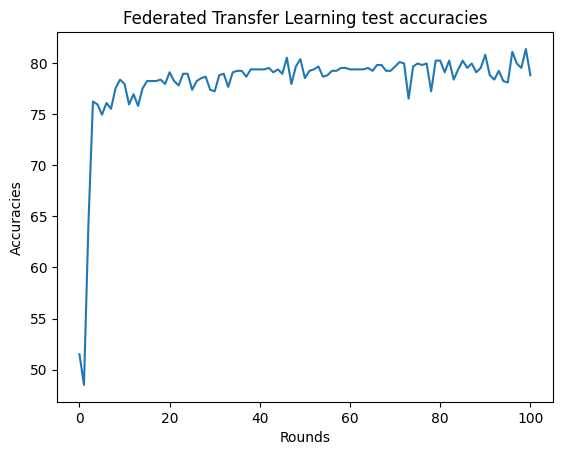

In [13]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')